# Analysis of the AMLTK Pipeline
OpenFE-like Analysis

### To Do for the User

In [15]:
# No more To Dos

### Imports


In [16]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Files

In [17]:
files = os.listdir(os.curdir)
parquet_files = []
for file in files:
    if file.endswith(".parquet") and not file.__contains__("tabular_data"):
        parquet_files.append(file)
print(parquet_files)

['results_internet_advertisements_dataset_original_0.parquet', 'results_bioresponse_dataset_autogluon_1.parquet', 'results_moneyball_dataset_autogluon_1.parquet', 'results_wine_quality_white_dataset_mljar_1.parquet', 'results_blood_transfusion_service_center_dataset_bioautoml_0.parquet', 'results_blood_transfusion_service_center_dataset_autogluon_1.parquet', 'results_pc4_dataset_mljar_2.parquet', 'results_wilt_dataset_mljar_2.parquet', 'results_churn_dataset_autofeat_0.parquet', 'results_australian_dataset_original_1.parquet', 'results_abalone_dataset_autogluon_0.parquet', 'results_credit_g_dataset_autofeat_0.parquet', 'results_gina_dataset_bioautoml_0.parquet', 'results_australian_dataset_original_0.parquet', 'results_gina_dataset_autogluon_0.parquet', 'results_bioresponse_dataset_autogluon_0.parquet', 'results_wine_quality_white_dataset_mljar_0.parquet', 'results_moneyball_dataset_autofeat_0.parquet', 'results_moneyball_dataset_autogluon_0.parquet', 'results_blood_transfusion_service

In [18]:
df_all = pd.DataFrame(columns=['Dataset', 'Method', 'Fold', 'Value'])

for file in parquet_files:
    print(file)
    core_name = file[len('results_'):-len('.parquet')]
    parts = core_name.split('_')
    if parts[1] == "dataset":
        dataset = parts[0]
        method = parts[2]
        fold = parts[3]
    elif parts[2] == "dataset":
        dataset = parts[0] + parts[1]
        method = parts[3]
        fold = parts[4]
    elif parts[3] == "dataset":
        dataset = parts[0] + parts[1] + parts[2]
        method = parts[4]
        fold = parts[5]
    
    df = pd.read_parquet(file)
    df = df[df['status'] == 'success']
    try:
        metric_accuracy = df["metric:roc_auc_ovo [0.0, 1.0] (maximize)"].tolist()
        value = np.average(metric_accuracy)
        df_all = df_all._append({'Dataset': dataset, 'Method': method, 'Fold': fold, 'Value': value}, ignore_index=True)
    except KeyError as e:
        print(str(e) + " for file " + str(file))
print(df_all)

results_internet_advertisements_dataset_original_0.parquet
results_bioresponse_dataset_autogluon_1.parquet
results_moneyball_dataset_autogluon_1.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_moneyball_dataset_autogluon_1.parquet
results_wine_quality_white_dataset_mljar_1.parquet
'metric:roc_auc_ovo [0.0, 1.0] (maximize)' for file results_wine_quality_white_dataset_mljar_1.parquet
results_blood_transfusion_service_center_dataset_bioautoml_0.parquet
results_blood_transfusion_service_center_dataset_autogluon_1.parquet
results_pc4_dataset_mljar_2.parquet
results_wilt_dataset_mljar_2.parquet
results_churn_dataset_autofeat_0.parquet
results_australian_dataset_original_1.parquet
results_abalone_dataset_autogluon_0.parquet
results_credit_g_dataset_autofeat_0.parquet
results_gina_dataset_bioautoml_0.parquet
results_australian_dataset_original_0.parquet
results_gina_dataset_autogluon_0.parquet
results_bioresponse_dataset_autogluon_0.parquet
results_wine_quality_white_datase

In [19]:
# Standard Deviation
df_stddev = df_all.groupby(['Dataset', 'Method'])['Value'].std().reset_index()
df_stddev.rename(columns={'Value': 'StdDev'}, inplace=True)
df_stddev['StdDev'] = df_stddev['StdDev'].fillna(0)
# Average values
df_summary = df_all.groupby(['Dataset', 'Method'])['Value'].mean().reset_index().fillna(0)

In [20]:
# Add standard deviation to the averages values
df_summary = pd.merge(df_summary, df_stddev)
df_summary['Value_with_StdDev'] = df_summary.apply(lambda row: f"{row['Value']} ± {row['StdDev']}", axis=1)

In [21]:
# Print and write to file
pivot_table = df_summary.pivot(index='Dataset', columns='Method', values='Value_with_StdDev').fillna('0 ± 0')
pivot_table.reset_index(inplace=True)
pivot_table.to_parquet('tabular_data.parquet')
print(tabulate(pivot_table, headers='keys', tablefmt='pretty'))

+----+------------------------+--------------------------+-------------------------------------------+--------------------------+--------------------------+------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+
|    |        Dataset         |         autofeat         |                 autogluon                 |        bioautoml         |          boruta          |            correlationBasedFS            |                    h2o                    |                   mljar                    |                 original                  |
+----+------------------------+--------------------------+-------------------------------------------+--------------------------+--------------------------+------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------------+
|

### Boxplots

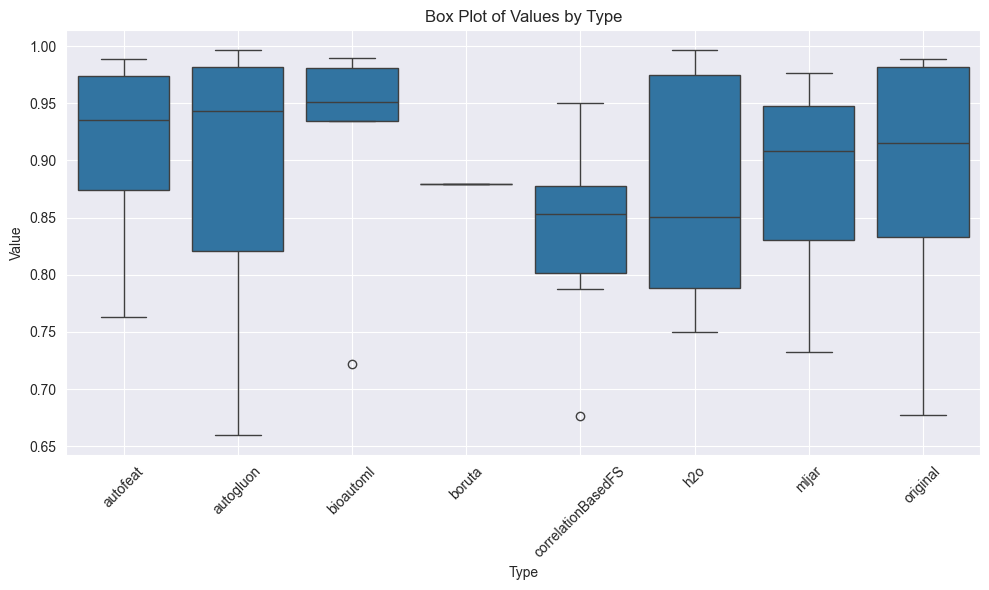

In [26]:
# Extract values
def extract_value(value_with_stddev):
    value, _ = value_with_stddev.split(' ± ')
    if float(value) == float(0):
        return None
    else:
        return float(value)

pivot_table_numeric = pivot_table.set_index('Dataset').applymap(extract_value).reset_index()

# Melt DataFrame to format for seaborn
melted_df = pd.melt(pivot_table_numeric, id_vars=['Dataset'], var_name='Type', value_name='Value')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Type', y='Value', data=melted_df)
plt.xlabel("Type")
plt.ylabel("Value")
plt.title("Box Plot of Values by Type")
plt.xticks(rotation=45)  # Rotate x-axis labels if necessary
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/box_plot.png')
plt.show()